##### This model follows the same fine tuning process as model 08 with the maximum input lengths increased again. 

# Imports

In [2]:
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, create_optimizer
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
import random
import matplotlib.pyplot as plt

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Read in data

In [5]:
data = load_dataset(
    'csv', data_files={
        'train':'./modeling_data/training_data.csv',
        'test':'./modeling_data/testing_data.csv',
        'validation':'./modeling_data/validation_data.csv'
        }
    )

Using custom data configuration default-74d066c3e8549d77


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-74d066c3e8549d77/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

# Pre-process data for input to model
code from https://huggingface.co/course/chapter7/5?fw=tf

## Set up model tokenizer

In [6]:
model_checkpoint = 'sshleifer/distilbart-xsum-1-1'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

## Tokenize data

In [7]:
def preprocess_function(text_data):
  model_inputs = tokenizer(
      text_data['chapter_text'], max_length=2048, truncation=True)     

  with tokenizer.as_target_tokenizer():
    labels = tokenizer(
        text_data['chapter_summary'], max_length=2048, truncation=True)   
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

In [9]:
tokenized_data = data.map(preprocess_function)

0ex [00:00, ?ex/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-74d066c3e8549d77/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-b2de3c4869ca5221.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-74d066c3e8549d77/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-db5e16f0678f77a9.arrow


# Fine tune model

## Set up model

In [10]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/317M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBartForConditionalGeneration.

All the layers of TFBartForConditionalGeneration were initialized from the model checkpoint at sshleifer/distilbart-xsum-1-1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


## Final processing of data for input to model

### Remove non-encoded columns from tokenized_data

In [11]:
tokenized_data_features = tokenized_data.remove_columns(
    data['train'].column_names
)

### Set up data collator to dynmaically pad inputs and labels

In [12]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors='tf')

### Use data collator to perform final processing on tokenized_data_features for input to model

In [13]:
tf_train = tokenized_data_features['train'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=True,
    batch_size=1
)

tf_validation = tokenized_data_features['validation'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=1
)

## Set up model hyperparamaters

In [14]:
num_train_epochs = 25
num_train_steps = len(tf_train) * num_train_epochs

optimizer, schedule = create_optimizer(
    init_lr=5.6e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)

## Compile model

In [15]:
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! Please ensure your labels are passed as keys in the input dict so that they are accessible to the model during the forward pass. To disable this behaviour, please pass a loss argument, or explicitly pass loss=None if you do not want your model to compute a loss.


## Fit model

In [16]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

In [17]:
model_history = model.fit(tf_train, validation_data=tf_validation, callbacks=[early_stop], epochs=25)

Epoch 1/25
212/212 [==============================] - 40s 140ms/step - loss: 5.7745 - val_loss: 5.0557
Epoch 2/25
212/212 [==============================] - 29s 135ms/step - loss: 4.9650 - val_loss: 4.8297
Epoch 3/25
212/212 [==============================] - 29s 136ms/step - loss: 4.6257 - val_loss: 4.7030
Epoch 4/25
212/212 [==============================] - 29s 136ms/step - loss: 4.3819 - val_loss: 4.6451
Epoch 5/25
212/212 [==============================] - 29s 135ms/step - loss: 4.1746 - val_loss: 4.6196
Epoch 6/25
212/212 [==============================] - 29s 136ms/step - loss: 3.9960 - val_loss: 4.6034
Epoch 7/25
212/212 [==============================] - 29s 135ms/step - loss: 3.8278 - val_loss: 4.6259
Epoch 8/25
212/212 [==============================] - 29s 134ms/step - loss: 3.6799 - val_loss: 4.6438
Epoch 9/25
212/212 [==============================] - 29s 135ms/step - loss: 3.5414 - val_loss: 4.6561
Epoch 10/25
212/212 [==============================] - 29s 136ms/step - l

# Visualize model

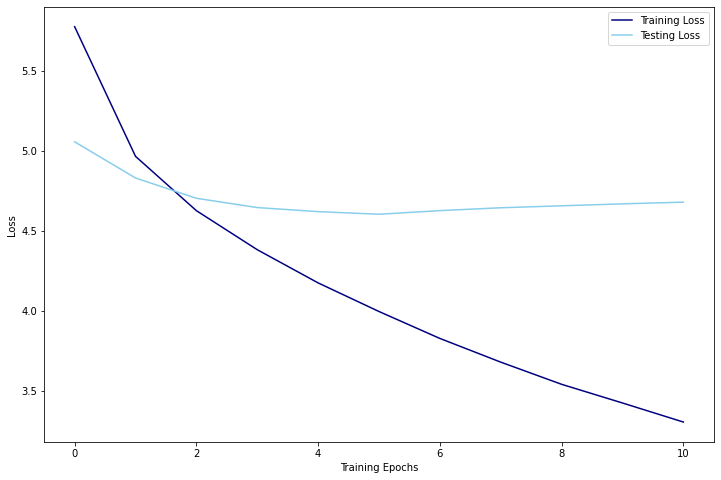

In [18]:
train_loss = model_history.history['loss']
validation_loss = model_history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training Loss', color='navy')
plt.plot(validation_loss, label='Testing Loss', color='skyblue')
plt.xlabel('Training Epochs')
plt.ylabel('Loss')
plt.legend();

The loss for the validation data in the model is higher than the loss for the training data, indicating that the model is overfitting. The loss functions of this model look very similar to those of model 8.

# Rouge scores for training data

In [19]:
train_labels = []
train_preds = []

for batch in tqdm(tf_train):
    predictions = model.generate(batch['input_ids'])
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = batch["labels"].numpy()
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    train_preds.extend(decoded_preds)
    train_labels.extend(decoded_labels)


100%|██████████| 212/212 [30:43<00:00,  8.70s/it]


In [20]:
rouge = load_metric('rouge')

train_results = rouge.compute(
    predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

for key in list(train_results.keys()):
  mid_scores = train_results[key].mid
  print(key)
  print(f'precision: {mid_scores[0]*100}')
  print(f'recall: {mid_scores[1]*100}')
  print(f'f-measure: {mid_scores[2]*100}')
  print('***************')

Downloading:   0%|          | 0.00/2.16k [00:00<?, ?B/s]

rouge1
precision: 78.72340425531915
recall: 25.0
f-measure: 37.948717948717956
***************
rouge2
precision: 32.608695652173914
recall: 10.204081632653061
f-measure: 15.544041450777202
***************
rougeL
precision: 40.42553191489361
recall: 12.837837837837837
f-measure: 19.48717948717949
***************
rougeLsum
precision: 76.59574468085107
recall: 24.324324324324326
f-measure: 36.92307692307693
***************


# Rouge scores for test data

In [21]:
tf_test = tokenized_data_features['test'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=1
)

In [22]:
test_labels = []
test_preds = []

for batch in tqdm(tf_test):
    predictions = model.generate(batch['input_ids'])
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = batch["labels"].numpy()
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    test_preds.extend(decoded_preds)
    test_labels.extend(decoded_labels)

100%|██████████| 59/59 [09:21<00:00,  9.52s/it]


In [23]:
rouge = load_metric('rouge')

test_results = rouge.compute(
    predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

for key in list(test_results.keys()):
  mid_scores = test_results[key].mid
  print(key)
  print(f'precision: {mid_scores[0]*100}')
  print(f'recall: {mid_scores[1]*100}')
  print(f'f-measure: {mid_scores[2]*100}')
  print('***************')

rouge1
precision: 62.0
recall: 13.537117903930133
f-measure: 22.222222222222225
***************
rouge2
precision: 4.081632653061225
recall: 0.8771929824561403
f-measure: 1.444043321299639
***************
rougeL
precision: 40.0
recall: 8.73362445414847
f-measure: 14.336917562724013
***************
rougeLsum
precision: 50.0
recall: 10.91703056768559
f-measure: 17.921146953405017
***************


# Example model-generated summaries

In [24]:
rand_indexes = []
for i in range(3):
  rand_indexes.append(random.randint(0,59))

In [25]:
print(rand_indexes)

[40, 9, 14]


In [26]:
#Reference summary example 1
print(test_labels[40])

Sir Toby, Sir Andrew, and the Fool are having a late night party.
Maria enters and tries to make them be quiet, but the Malvolio comes and threatens to kick them out if they do not behave better.
In defense to Malvolio's attitude, Maria decides to forge a letter from Olivia telling Malvolio that she loves him.
Toby, Andrew, and Feste think it is a wonderful idea, and she leaves to put her plan into action.
Sir Andrew reveals his bad financial state to Sir Toby, saying that he has to marry Olivia or he will be completely broke.


In [28]:
#Model summary example 1
print(test_preds[40])

In this chapter, Sir Toby, Sir Andrew, delighted by Sir Toby.


In [29]:
#Reference summary example 2
print(test_labels[9])

: Rosalind enters as the boy actor who played her, and encourages the men and women in the audience to fall in love.


In [30]:
#Model summary example 2
print(test_preds[9])

Orlando, Orlando, dressed as a fool, and Celia, and Touchstone enter the forest.
He tells him that he has no chance to marry her and asks him if he wants to marry him.
She tells him about his future.
The Duke's daughter, and


In [31]:
#Reference summary example 3
print(test_labels[14])

Zosimov is a doctor and friend of Razumikhin.
When he and Razumikhin begin discussing the murders, Raskolnikov turns away from them as he lies on his couch and faces the wall, studying the wallpaper.
Razumikhin and Zosimov heatedly argue over whether the painters could be suspects in the crime.
Razumikhin strongly believes they could not have committed it, since they were behaving so jovially immediately following the murder.
Suddenly a strange man enters the room.
The man turns out to be Peter Petrovich Luzhin, Dunia's fianc�.
He is stiff and awkward in his greeting and is met with hostility from Raskolnikov, who suspects (rightly) that he is out to stroke his vanity by marrying a poor woman.
He is well-dressed and fresh-scrubbed, in contrast to the squalor of the students' appearance and Raskolnikov's living conditions.
Luzhin makes an embarrassing attempt to flatter the youth of today, but is met with disagreement and contempt by the young men (Luzhin is 45).
Raskolnikov asks Luzhin

In [32]:
#Model summary example 3
print(test_preds[14])

Raskolnikov tells Razumikhin that he has been arrested on suspicion of murder.
He tells him that he should not be able to find him guilty of murdering him.
He has been told him he would have to go to the house of the next morning, Razum


# Evaluation of model

Based on rouge scores, this model performed better than the baseline and mostly better than previous finetuned models. This model scores lower than the previous model on RougeL f-score, and the same as the previous model on RougeLsum f-score. The model-generated summaries have similar readability/logic to the previous model.